In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_auc_score,roc_curve,auc
import math

from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

/Users/limeng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#读取数据
data = pd.read_csv(r"rankingcard.csv",index_col=0)
data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149996,0,0.040674,74,0,0.225131,2100.0,4,0,1,0,0.0
149997,0,0.299745,44,0,0.716562,5584.0,4,0,1,0,2.0
149998,0,0.246044,58,0,3870.000000,NaN,18,0,1,0,0.0
149999,0,0.000000,30,0,0.000000,5716.0,4,0,0,0,0.0


In [3]:
#查看数据
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    return summary

train_summary=resumetable(data)
print(train_summary)

Dataset Shape: (150000, 11)
                                    Name   dtypes  Missing  Uniques
0                       SeriousDlqin2yrs    int64        0        2
1   RevolvingUtilizationOfUnsecuredLines  float64        0   125728
2                                    age    int64        0       86
3   NumberOfTime30-59DaysPastDueNotWorse    int64        0       16
4                              DebtRatio  float64        0   114194
5                          MonthlyIncome  float64    29731    13594
6        NumberOfOpenCreditLinesAndLoans    int64        0       58
7                NumberOfTimes90DaysLate    int64        0       19
8           NumberRealEstateLoansOrLines    int64        0       28
9   NumberOfTime60-89DaysPastDueNotWorse    int64        0       13
10                    NumberOfDependents  float64     3924       13


In [4]:
#去除重复值
data[data.duplicated()]
data.drop_duplicates(inplace=True)
data.info()
#恢复索引
data.index = range(data.shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149391 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    145563 non-null  float64
dtype

In [5]:
#去除缺失值
#查看缺失值的比例
data.isnull().sum()/data.shape[0]

SeriousDlqin2yrs                        0.000000
RevolvingUtilizationOfUnsecuredLines    0.000000
age                                     0.000000
NumberOfTime30-59DaysPastDueNotWorse    0.000000
DebtRatio                               0.000000
MonthlyIncome                           0.195601
NumberOfOpenCreditLinesAndLoans         0.000000
NumberOfTimes90DaysLate                 0.000000
NumberRealEstateLoansOrLines            0.000000
NumberOfTime60-89DaysPastDueNotWorse    0.000000
NumberOfDependents                      0.025624
dtype: float64

In [6]:
#均值填补缺失值
data['NumberOfDependents'].fillna(data['NumberOfDependents'].mean(),inplace=True)
data.info()
data.index=range(data.shape[0])

#由于MonthlyIncome缺失值较多，这里通过随机森林对缺失值进行填补
def fill_missing_rf(X,y,to_fill):

    """
    使用随机森林填补一个特征的缺失值的函数

    参数：
    X：要填补的特征矩阵
    y：完整的，没有缺失值的标签
    to_fill：字符串，要填补的那一列的名称
    """

    #构建我们的新特征矩阵和新标签
    df = X.copy()
    fill = df.loc[:,to_fill]
    df = pd.concat([df.loc[:,df.columns != to_fill],pd.DataFrame(y)],axis=1)

    # 找出我们的训练集和测试集
    Ytrain = fill[fill.notnull()]
    Ytest = fill[fill.isnull()]
    Xtrain = df.iloc[Ytrain.index,:]
    Xtest = df.iloc[Ytest.index,:]

    #用随机森林回归来填补缺失值
    from sklearn.ensemble import RandomForestRegressor as rfr
    rfr = rfr(n_estimators=100)
    rfr = rfr.fit(Xtrain, Ytrain)
    Ypredict = rfr.predict(Xtest)

    return Ypredict

X = data.iloc[:,1:]
y = data["SeriousDlqin2yrs"]
X.shape#(149391, 10)
#训练得到缺失值预测结果
y_pred = fill_missing_rf(X,y,"MonthlyIncome")
#用训练结果填补缺失值
data.loc[data.loc[:,"MonthlyIncome"].isnull(),"MonthlyIncome"] = y_pred

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149391 entries, 0 to 149390
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149391 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149391 non-null  float64
 2   age                                   149391 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149391 non-null  int64  
 4   DebtRatio                             149391 non-null  float64
 5   MonthlyIncome                         120170 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149391 non-null  int64  
 7   NumberOfTimes90DaysLate               149391 non-null  int64  
 8   NumberRealEstateLoansOrLines          149391 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149391 non-null  int64  
 10  NumberOfDependents                    149391 non-null  float64
dtype

In [7]:
#异常值
#age不能小于等于0
data = data[data["age"] != 0]

In [8]:
data.loc[:,"NumberOfTimes90DaysLate"].value_counts()

0     141107
1       5232
2       1555
3        667
4        291
98       220
5        131
6         80
7         38
8         21
9         19
10         8
96         5
11         5
13         4
15         2
14         2
12         2
17         1
Name: NumberOfTimes90DaysLate, dtype: int64

In [9]:
#有225个样本存在这样的情况，并且这些样本，我们观察一下，标签并不都是1，他们并不都是坏客户。因此，我们基
# 本可以判断，这些样本是某种异常，应该把它们删除。
 
data = data[data.loc[:,"NumberOfTimes90DaysLate"] < 90]
#恢复索引
data.index = range(data.shape[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149165 entries, 0 to 149164
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      149165 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  149165 non-null  float64
 2   age                                   149165 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  149165 non-null  int64  
 4   DebtRatio                             149165 non-null  float64
 5   MonthlyIncome                         149165 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       149165 non-null  int64  
 7   NumberOfTimes90DaysLate               149165 non-null  int64  
 8   NumberRealEstateLoansOrLines          149165 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  149165 non-null  int64  
 10  NumberOfDependents                    149165 non-null  float64
dtype

In [10]:
#探索数据分布
#探索标签分布情况
data.loc[:,'SeriousDlqin2yrs'].mean()

0.06618844903295008

In [11]:
#发现1类样本仅占6.6%，样本偏态严重
#利用SMOTE进行上取样: 对于少数类样本a, 随机选择一个最近邻的样本b, 然后从a与b的连线上随机选取一个点c作为新的少数类样本;

x=data.iloc[:,1:]
y=data.iloc[:,0]

import imblearn
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
x,y=sm.fit_resample(x,y)

n_sample=x.shape[0]
pd.Series(y).value_counts()

1    139292
0    139292
Name: SeriousDlqin2yrs, dtype: int64

In [12]:
#划分训练集和测试集
from sklearn.model_selection import train_test_split
x=pd.DataFrame(x)
y=pd.DataFrame(y)
xtrain,xvali,ytrain,yvali=train_test_split(x,y,test_size=0.3,random_state=420)

model_data=pd.concat([ytrain,xtrain],axis=1)
model_data.index=range(model_data.shape[0])
model_data.columns=data.columns
vali_data=pd.concat([yvali,xvali],axis=1)
vali_data.index=range(vali_data.shape[0])
vali_data.columns=data.columns

#数据存储
model_data.to_csv('model_data4.6.csv')
vali_data.to_csv('vali_data4.6.csv')

In [13]:
model_data

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.015404,53,0,0.121802,4728.000000,5,0,0,0,0.000000
1,0,0.168311,63,0,0.141964,1119.000000,5,0,0,0,0.000000
2,1,1.063570,39,1,0.417663,3500.000000,5,1,0,2,3.716057
3,0,0.088684,73,0,0.522822,5301.000000,11,0,2,0,0.000000
4,1,0.622999,53,0,0.423650,13000.000000,9,0,2,0,0.181999
...,...,...,...,...,...,...,...,...,...,...,...
195003,1,0.916269,32,2,0.548132,6000.000000,10,0,1,0,3.966830
195004,1,0.484728,50,1,0.370603,5258.000000,12,0,1,0,2.000000
195005,1,0.850447,46,0,0.562610,8000.000000,9,0,1,0,2.768793
195006,0,1.000000,64,0,0.364694,10309.000000,7,0,3,0,0.000000


### 分箱

通过分箱，离散化连续变量，让拥有不同的人别分成不同类别，打上不同的分数。离散化连续变量必然伴随信息损失，箱子越少，信息损失越大；

因此为了衡量特征上的信息量，以及特征对预测函数的贡献，IV代表特征上的信息以及这个特征对模型的贡献，IV越大，对模型贡献度越大；

要找到IV值的大小和箱子个数的平衡点，箱子越多，IV越小，因此要通过IV曲线寻找合适的分箱个数。

In [14]:
import matplotlib.pyplot as plt
import scipy

model_data=pd.read_csv('model_data4.6.csv',index_col=0)

#不能使用自动分箱的变量
hand_bins = {"NumberOfTime30-59DaysPastDueNotWorse":[0,1,2,13]
            ,"NumberOfTimes90DaysLate":[0,1,2,17]
            ,"NumberRealEstateLoansOrLines":[0,1,2,4,54]
            ,"NumberOfTime60-89DaysPastDueNotWorse":[0,1,2,8]
            ,"NumberOfDependents":[0,1,2,3]}

auto_col_bins=['RevolvingUtilizationOfUnsecuredLines','age','DebtRatio','MonthlyIncome','NumberOfOpenCreditLinesAndLoans']

In [15]:
def graphforbestbin(DF, X, Y, n=5,q=20,graph=True):
    '''
    自动最优分箱函数，基于卡方检验的分箱

    参数：
    DF: 需要输入的数据
    X: 需要分箱的列名
    Y: 分箱数据对应的标签 Y 列名
    n: 保留分箱个数
    q: 初始分箱的个数
    graph: 是否要画出IV图像

    区间为前开后闭 (]

    '''
    
    DF = DF[[X,Y]].copy()

    DF["qcut"],bins = pd.qcut(DF[X], retbins=True, q=q,duplicates="drop")
    coount_y0 = DF.loc[DF[Y]==0].groupby(by="qcut").count()[Y]
    coount_y1 = DF.loc[DF[Y]==1].groupby(by="qcut").count()[Y]
    num_bins = [*zip(bins,bins[1:],coount_y0,coount_y1)]

    for i in range(q):
        if 0 in num_bins[0][2:]:
            num_bins[0:2] = [(
                num_bins[0][0],
                num_bins[1][1],
                num_bins[0][2]+num_bins[1][2],
                num_bins[0][3]+num_bins[1][3])]
            continue

        for i in range(len(num_bins)):
            if 0 in num_bins[i][2:]:
                num_bins[i-1:i+1] = [(
                    num_bins[i-1][0],
                    num_bins[i][1],
                    num_bins[i-1][2]+num_bins[i][2],
                    num_bins[i-1][3]+num_bins[i][3])]
                break
        else:
            break

    def get_woe(num_bins):
        columns = ["min","max","count_0","count_1"]
        df = pd.DataFrame(num_bins,columns=columns)
        df["total"] = df.count_0 + df.count_1
        df["percentage"] = df.total / df.total.sum()
        df["bad_rate"] = df.count_1 / df.total
        df["good%"] = df.count_0/df.count_0.sum()
        df["bad%"] = df.count_1/df.count_1.sum()
        df["woe"] = np.log(df["bad%"] / df["good%"])#WOE用坏好比时，要求逻辑回归系数为正；WOE用好坏比时，逻辑回归系数为负。
        return df

    def get_iv(df):
        rate = df["bad%"] - df["good%"]
        iv = np.sum(rate * df.woe)
        return iv

    IV = []
    axisx = []
    while len(num_bins) > n:
        pvs = []
        for i in range(len(num_bins)-1):
            x1 = num_bins[i][2:]
            x2 = num_bins[i+1][2:]
            pv = scipy.stats.chi2_contingency([x1,x2])[1]
            pvs.append(pv)

        i = pvs.index(max(pvs))
        num_bins[i:i+2] = [(
            num_bins[i][0],
            num_bins[i+1][1],
            num_bins[i][2]+num_bins[i+1][2],
            num_bins[i][3]+num_bins[i+1][3])]

        bins_df = pd.DataFrame(get_woe(num_bins))
        axisx.append(len(num_bins))
        IV.append(get_iv(bins_df))
        
    if graph:
        plt.figure()
        plt.plot(axisx,IV)
        plt.xticks(axisx)
        plt.xlabel("number of box")
        plt.ylabel("IV")
        plt.show()
    return bins_df

RevolvingUtilizationOfUnsecuredLines


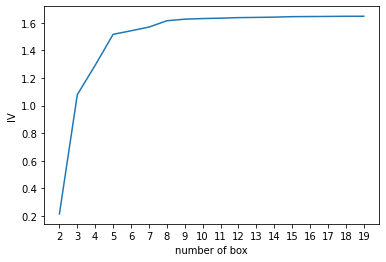

age


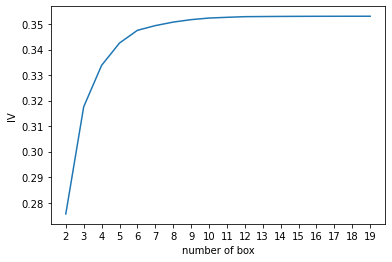

DebtRatio


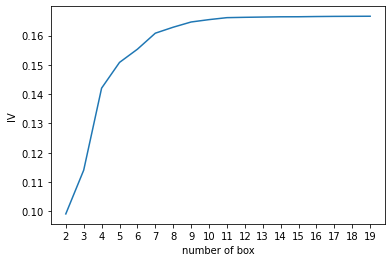

MonthlyIncome


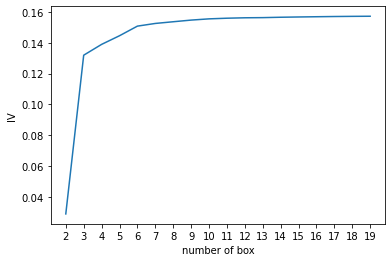

NumberOfOpenCreditLinesAndLoans


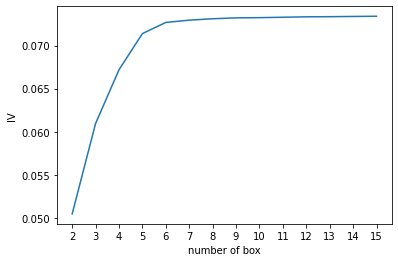

In [16]:
for i in model_data[auto_col_bins]:
    print(i)
    bins_df=graphforbestbin(model_data,i,'SeriousDlqin2yrs',n=2,q=20)

In [17]:
#iv值下降最快的结点作为分箱个数
auto_col_bins = {"RevolvingUtilizationOfUnsecuredLines":7,
                "age":5,
                "DebtRatio":4,
                "MonthlyIncome":3,
                "NumberOfOpenCreditLinesAndLoans":5}
hand_bins = {k:[-np.inf,*v[:-1],np.inf] for k,v in hand_bins.items()}

bins_of_col = {}
# 生成自动分箱的分箱区间和分箱后的 IV 值
 
for col in auto_col_bins:
    bins_df = graphforbestbin(model_data,col
                             ,"SeriousDlqin2yrs"
                             ,n=auto_col_bins[col]#特征所对应的箱的数量
                             ,q=20
                             ,graph=False)
    bins_list = sorted(set(bins_df["min"]).union(bins_df["max"]))
    #保证区间覆盖使用 np.inf 替换最大值 -np.inf 替换最小值
    bins_list[0],bins_list[-1] = -np.inf,np.inf
    bins_of_col[col] = bins_list
    
#合并手动分箱数据    
bins_of_col.update(hand_bins)
 
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09912560690151183,
  0.2982941630149276,
  0.46549630918427853,
  0.7229490092198179,
  0.982165669211439,
  0.9999999,
  inf],
 'age': [-inf, 43.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf,
  0.01729364549068779,
  0.320559813,
  1.4669356788269436,
  inf],
 'MonthlyIncome': [-inf, 0.1, 5600.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [18]:
#调整分箱bivar
bins_of_col['DebtRatio']=[-np.inf, 0.017169933500000005, 0.36021332909031206, np.inf]

In [19]:
def get_badrate(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    bins_df['bade_rate']=bins_df[0]/(bins_df[0]+bins_df[1])
    #woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return bins_df
 
#将所有特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_badrate(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])
    
woeall

{'RevolvingUtilizationOfUnsecuredLines': SeriousDlqin2yrs      0      1  bade_rate
 cut                                      
 (-inf, 0.0991]    43928   4824   0.901050
 (0.0991, 0.298]   19375   9876   0.662371
 (0.298, 0.465]     9141  10360   0.468745
 (0.465, 0.723]     9248  20003   0.316160
 (0.723, 0.982]     8164  30837   0.209328
 (0.982, 1.0]       6364  10177   0.384741
 (1.0, inf]         1471  11240   0.115727,
 'age': SeriousDlqin2yrs      0      1  bade_rate
 cut                                      
 (-inf, 43.0]      27937  43878   0.389013
 (43.0, 54.0]      25930  32355   0.444883
 (54.0, 61.0]      15743  12275   0.561889
 (61.0, 74.0]      20344   7417   0.732827
 (74.0, inf]        7737   1392   0.847519,
 'DebtRatio': SeriousDlqin2yrs      0      1  bade_rate
 cut                                      
 (-inf, 0.0172]     7955   1768   0.818163
 (0.0172, 0.36]    40238  37844   0.515330
 (0.36, inf]       49498  57705   0.461722,
 'MonthlyIncome': SeriousDlqin2yrs

In [20]:
bins_of_col

{'RevolvingUtilizationOfUnsecuredLines': [-inf,
  0.09912560690151183,
  0.2982941630149276,
  0.46549630918427853,
  0.7229490092198179,
  0.982165669211439,
  0.9999999,
  inf],
 'age': [-inf, 43.0, 54.0, 61.0, 74.0, inf],
 'DebtRatio': [-inf, 0.017169933500000005, 0.36021332909031206, inf],
 'MonthlyIncome': [-inf, 0.1, 5600.0, inf],
 'NumberOfOpenCreditLinesAndLoans': [-inf, 1.0, 3.0, 5.0, 17.0, inf],
 'NumberOfTime30-59DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfTimes90DaysLate': [-inf, 0, 1, 2, inf],
 'NumberRealEstateLoansOrLines': [-inf, 0, 1, 2, 4, inf],
 'NumberOfTime60-89DaysPastDueNotWorse': [-inf, 0, 1, 2, inf],
 'NumberOfDependents': [-inf, 0, 1, 2, inf]}

In [21]:
def get_woe(df,col,y,bins):
    df = df[[col,y]].copy()
    df["cut"] = pd.cut(df[col],bins)
    bins_df = df.groupby("cut")[y].value_counts().unstack()
    woe = bins_df["woe"] = np.log((bins_df[0]/bins_df[0].sum())/(bins_df[1]/bins_df[1].sum()))
    return woe
 
#将所有特征的WOE存储到字典当中
woeall = {}
for col in bins_of_col:
    woeall[col] = get_woe(model_data,col,"SeriousDlqin2yrs",bins_of_col[col])

In [22]:
model_woe = pd.DataFrame(index=model_data.index)

#对所有特征操作可以写成：
for col in bins_of_col:
    model_woe[col] = pd.cut(model_data[col],bins_of_col[col]).map(woeall[col])
    
#将标签补充到数据中
model_woe["SeriousDlqin2yrs"] = model_data["SeriousDlqin2yrs"]
 
#这就是我们的建模数据了
model_woe.head()

,RevolvingUtilizationOfUnsecuredLines,age,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTime30-59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,SeriousDlqin2yrs
0,2.205113,-0.225204,0.057504,-0.234221,-0.055443,0.351967,0.23675,-0.392209,0.124246,0.659779,0
1,0.670040,1.005176,0.057504,-0.234221,-0.055443,0.351967,0.23675,-0.392209,0.124246,0.659779,0
2,-2.037372,-0.455297,-0.157247,-0.234221,-0.055443,-0.872207,-1.76131,-0.392209,-1.768208,-0.479768,1
3,2.205113,1.005176,-0.157247,-0.234221,0.122589,0.351967,0.23675,0.614737,0.124246,0.659779,0
4,-0.775311,-0.225204,-0.157247,0.233301,0.122589,0.351967,0.23675,0.614737,0.124246,-0.509571,1


In [23]:
#通过同样的方式，映射测试集vali
vali_data = pd.read_csv('vali_data4.6.csv',index_col=0)
vali_woe = pd.DataFrame(index=vali_data.index)

for col in bins_of_col:
    vali_woe[col] = pd.cut(vali_data[col],bins_of_col[col]).map(woeall[col])
vali_woe["SeriousDlqin2yrs"] = vali_data["SeriousDlqin2yrs"]
 
vali_X = vali_woe.iloc[:,:-1]
vali_y = vali_woe.iloc[:,-1]

In [24]:
#使用罗辑回归进行建模
X = model_woe.iloc[:,:-1]
y = model_woe.iloc[:,-1]
 
from sklearn.linear_model import LogisticRegression as LR
 
lr = LR().fit(X,y)
#lr.score(vali_X,vali_y)#0.8641356370249832

In [25]:
#ROC
def plotROC(y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[2], tpr[2], _ = roc_curve(y_test, y_score)
    roc_auc[2] = auc(fpr[2], tpr[2])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test, y_score)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # plot it
    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [26]:
y_pred = lr.predict_proba(X)[:,1]
fpr_lr_train,tpr_lr_train,_ = roc_curve(y,y_pred)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print('train_ks : ',train_ks)

y_pred = lr.predict_proba(vali_X)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(vali_y,y_pred)
val_ks = abs(fpr_lr - tpr_lr).max()
print('val_ks : ',val_ks)

train_auc=auc(fpr_lr_train, tpr_lr_train)
print('train_auc:',train_auc)

val_auc=auc(fpr_lr,tpr_lr)
print('val_auc:',val_auc)

train_ks :  0.5759867674200546
val_ks :  0.5797228507887812
train_auc: 0.8677356134842213
val_auc: 0.8692981334533194


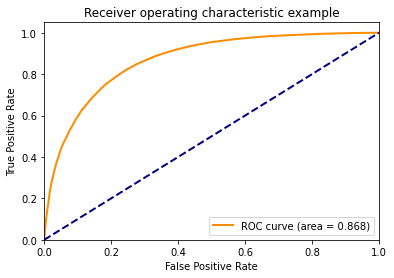

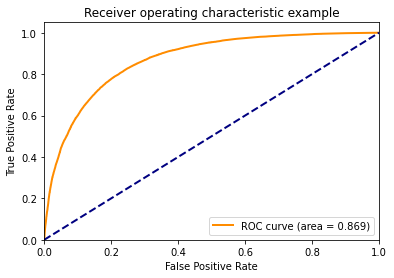

In [27]:
y_pred = lr.predict_proba(X)[:,1]
plotROC(y, y_pred)

y_pred = lr.predict_proba(vali_X)[:,1]
plotROC(vali_y, y_pred)

In [28]:
# 系数
print('系数：',lr.coef_)
print('截距：',lr.intercept_)

系数： [[-0.76251789 -0.27844876 -0.95178367 -0.62828305 -0.18760557 -0.53367849
  -0.56417855 -0.87601707 -0.2614076  -0.8631087 ]]
截距： [0.00028275]


- 生成报告

In [29]:
#生成报告
model = lr
row_num, col_num = 0, 0
bins = 20
Y_predict = [s[1] for s in model.predict_proba(vali_X)]

In [30]:
#生成报告
model = lr
row_num, col_num = 0, 0
bins = 20
Y_predict = [s[1] for s in model.predict_proba(vali_X)]
Y = vali_y
nrows = Y.shape[0]
lis = [(Y_predict[i], Y[i]) for i in range(nrows)]
ks_lis = sorted(lis, key=lambda x: x[0], reverse=True)
#排序
bin_num = int(nrows/bins+1)
bad = sum([1 for (p, y) in ks_lis if y > 0])
good = sum([1 for (p, y) in ks_lis if y <= 0])
bad_cnt, good_cnt = 0, 0
KS = []
BAD = []
GOOD = []
BAD_CNT = []
GOOD_CNT = []
BAD_PCTG = []
BADRATE = []
dct_report = {}
for j in range(bins):
    ds = ks_lis[j*bin_num: min((j+1)*bin_num, nrows)]
    bad1 = sum([1 for (p, y) in ds if y > 0])
    good1 = sum([1 for (p, y) in ds if y <= 0])
    bad_cnt += bad1
    good_cnt += good1
    bad_pctg = round(bad_cnt/sum(vali_y),3)
    badrate = round(bad1/(bad1+good1),3)
    ks = round(math.fabs((bad_cnt / bad) - (good_cnt / good)),3)
    KS.append(ks)
    BAD.append(bad1)
    GOOD.append(good1)
    BAD_CNT.append(bad_cnt)
    GOOD_CNT.append(good_cnt)
    BAD_PCTG.append(bad_pctg)
    BADRATE.append(badrate)
    dct_report['KS'] = KS
    dct_report['BAD'] = BAD
    dct_report['GOOD'] = GOOD
    dct_report['BAD_CNT'] = BAD_CNT
    dct_report['GOOD_CNT'] = GOOD_CNT
    dct_report['BAD_PCTG'] = BAD_PCTG
    dct_report['BADRATE'] = BADRATE
val_repot = pd.DataFrame(dct_report)
val_repot

,KS,BAD,GOOD,BAD_CNT,GOOD_CNT,BAD_PCTG,BADRATE
0,0.089,3951,228,3951,228,0.094,0.945
1,0.174,3877,302,7828,530,0.186,0.928
2,0.256,3812,367,11640,897,0.277,0.912
3,0.329,3619,560,15259,1457,0.364,0.866
4,0.396,3504,675,18763,2132,0.447,0.838
5,0.451,3255,924,22018,3056,0.525,0.779
6,0.499,3105,1074,25123,4130,0.599,0.743
7,0.537,2895,1284,28018,5414,0.667,0.693
8,0.565,2670,1509,30688,6923,0.731,0.639
9,0.578,2379,1800,33067,8723,0.788,0.569


In [31]:
from pyecharts.charts import *
from pyecharts import options as opts
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
np.set_printoptions(suppress=True)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
line = (

    Line()
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "分组坏人占比",
        list(val_repot.BADRATE),
        yaxis_index=0,
        color="red",
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="行为评分卡模型表现"),
    )
    .extend_axis(
        yaxis=opts.AxisOpts(
            name="累计坏人占比",
            type_="value",
            min_=0,
            max_=0.6,
            position="right",
            axisline_opts=opts.AxisLineOpts(
                linestyle_opts=opts.LineStyleOpts(color="red")
            ),
            axislabel_opts=opts.LabelOpts(formatter="{value}"),
        )

    )
    .add_xaxis(list(val_repot.index))
    .add_yaxis(
        "KS",
        list(val_repot['KS']),
        yaxis_index=1,
        color="blue",
        label_opts=opts.LabelOpts(is_show=False),
    )
)
line.render_notebook()

- 评分卡

In [42]:
B = 20/np.log(2)
A = 600 + B*np.log(1/60)
 
B,A

(28.85390081777927, 481.8621880878296)

In [41]:
base_score = A - B*lr.intercept_#lr.intercept_：截距
base_score#array([481.56390143])

array([481.85402968])

In [43]:
file = "./ScoreData.csv"
 
#open是用来打开文件的python命令，第一个参数是文件的路径+文件名，如果你的文件是放在根目录下，则你只需要文件名就好
#第二个参数是打开文件后的用途，"w"表示用于写入，通常使用的是"r"，表示打开来阅读
#首先写入基准分数
#之后使用循环，每次生成一组score_age类似的分档和分数，不断写入文件之中
 
with open(file,"w") as fdata:
    fdata.write("base_score,{}\n".format(base_score))
for i,col in enumerate(X.columns):#[*enumerate(X.columns)]
    score = woeall[col] * (-B*lr.coef_[0][i])
    score.name = "Score"
    score.index.name = col
    score.to_csv(file,header=True,mode="a")

In [45]:
ScoreData=pd.read_csv('./ScoreData.csv',header=0)
ScoreData

,base_score,[481.85402968]
0,RevolvingUtilizationOfUnsecuredLines,Score
1,"(-inf, 0.0991]",48.516042328650094
2,"(0.0991, 0.298]",14.741968148222965
3,"(0.298, 0.465]",-2.838608673570208
4,"(0.465, 0.723]",-17.05808780842079
5,"(0.723, 0.982]",-29.32412205225196
6,"(0.982, 1.0]",-10.413560574164723
7,"(1.0, inf]",-44.825478624182665
8,age,Score
9,"(-inf, 43.0]",-3.658006251153534
